<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/code/dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg"
              for i in range(start_index, end_index)]
    for fname in fnames:
        shutil.copyfile(src=original_dir / fname,
                        dst=dir / fname)

In [2]:
from google.colab import files

dirs_done = os.path.exists("cats_vs_dogs_small")
if not dirs_done:
  files.upload()
  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle competitions download -c dogs-vs-cats
  !unzip -qq dogs-vs-cats.zip
  !unzip -qq train.zip
  make_subset("train", start_index=0, end_index=1000)
  make_subset("validation", start_index=1000, end_index=1500)
  make_subset("test", start_index=1500, end_index=2500)

Saving kaggle.json to kaggle.json
 98% 796M/812M [00:07<00:00, 163MB/s]
100% 812M/812M [00:07<00:00, 116MB/s]


#Training a convnet from scratch

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [5]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [6]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",
    save_best_only=True,
    monitor="val_loss")
]

In [7]:
history = model.fit(
  train_dataset,
  epochs=30,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 19s 96ms/step - loss: 0.6977 - accuracy: 0.5125 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6935 - accuracy: 0.5130 - val_loss: 0.6861 - val_accuracy: 0.5860
Epoch 3/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6859 - accuracy: 0.5625 - val_loss: 0.6798 - val_accuracy: 0.5450
Epoch 4/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6513 - accuracy: 0.6150 - val_loss: 0.6174 - val_accuracy: 0.6740
Epoch 5/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6239 - accuracy: 0.6675 - val_loss: 0.6489 - val_accuracy: 0.6080
Epoch 6/30
63/63 [==============================] - 5s 79ms/step - loss: 0.5914 - accuracy: 0.6910 - val_loss: 0.5895 - val_accuracy: 0.6880
Epoch 7/30
63/63 [==============================] - 4s 62ms/step - loss: 0.5571 - accuracy: 0.7220 - val_loss: 0.6662 - val_accuracy: 0.6360
Epoch 8/30
6

In [8]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 33ms/step - loss: 0.5397 - accuracy: 0.7370
Test accuracy: 0.737


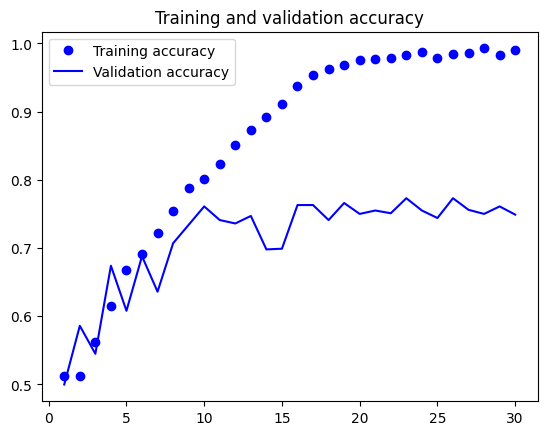

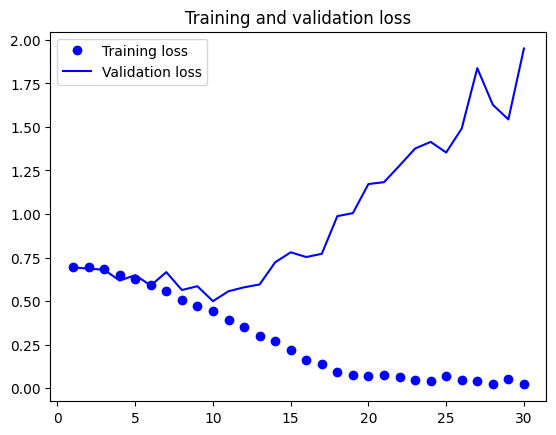

In [9]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#Using data augmentation

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

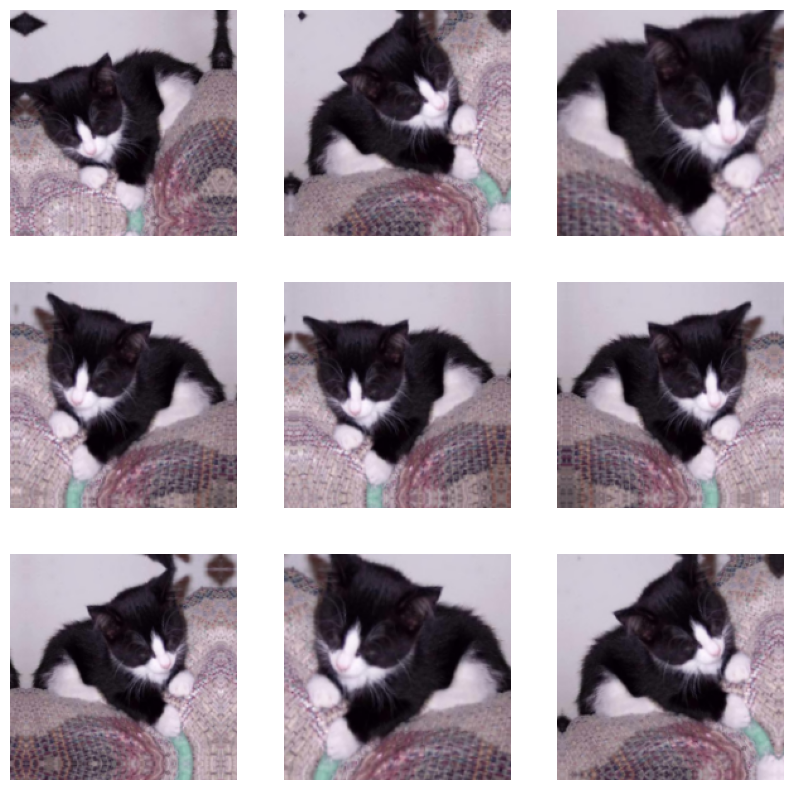

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [13]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
  train_dataset,
  epochs=100,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 7s 68ms/step - loss: 0.6992 - accuracy: 0.4985 - val_loss: 0.6927 - val_accuracy: 0.5030
Epoch 2/100
63/63 [==============================] - 5s 76ms/step - loss: 0.6953 - accuracy: 0.5110 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 5s 80ms/step - loss: 0.6926 - accuracy: 0.5335 - val_loss: 0.6813 - val_accuracy: 0.5790
Epoch 4/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6797 - accuracy: 0.5785 - val_loss: 0.6595 - val_accuracy: 0.5710
Epoch 5/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6579 - accuracy: 0.6215 - val_loss: 0.6679 - val_accuracy: 0.6080
Epoch 6/100
63/63 [==============================] - 5s 81ms/step - loss: 0.6520 - accuracy: 0.6120 - val_loss: 0.6629 - val_accuracy: 0.5680
Epoch 7/100
63/63 [==============================] - 4s 63ms/step - loss: 0.6321 - accuracy: 0.6495 - val_loss: 0.6606 - val_accuracy: 0.5740
Epoch 

In [14]:
test_model = keras.models.load_model(
  "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 33ms/step - loss: 0.5149 - accuracy: 0.8325
Test accuracy: 0.832


#Feature extraction with a pretrained model

In [15]:
conv_base = keras.applications.vgg16.VGG16(
  weights="imagenet",
  include_top=False)
conv_base.trainable = False
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction_with_data_augmentation.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
  train_dataset,
  epochs=50,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 17s 189ms/step - loss: 21.9331 - accuracy: 0.8940 - val_loss: 4.9487 - val_accuracy: 0.9650
Epoch 2/50
63/63 [==============================] - 9s 141ms/step - loss: 6.8139 - accuracy: 0.9430 - val_loss: 6.2596 - val_accuracy: 0.9700
Epoch 3/50
63/63 [==============================] - 9s 145ms/step - loss: 6.0775 - accuracy: 0.9575 - val_loss: 4.5722 - val_accuracy: 0.9710
Epoch 4/50
63/63 [==============================] - 9s 143ms/step - loss: 6.6547 - accuracy: 0.9520 - val_loss: 7.0712 - val_accuracy: 0.9590
Epoch 5/50
63/63 [==============================] - 9s 145ms/step - loss: 4.2961 - accuracy: 0.9595 - val_loss: 4.5734 - val_accuracy: 0.9760
Epoch 6/50
63/63 [==============================] - 9s 144ms/step - loss: 3.9602 - accuracy: 0.9660 - val_loss: 7.5154 - val_accuracy: 0.9600
Epoch 7/50
63/63 [==============================] - 9s 147ms/step - loss: 4.2541 - accuracy: 0.9670 - val_loss: 3.5072 - val_accuracy: 0.9770
Epoc

In [18]:
test_model = keras.models.load_model(
  "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 91ms/step - loss: 2.2895 - accuracy: 0.9740
Test accuracy: 0.974


In [19]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#Fine-tuning a pretrained model

In [20]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [21]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
  train_dataset,
  epochs=30,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 14s 167ms/step - loss: 0.4114 - accuracy: 0.9895 - val_loss: 1.1267 - val_accuracy: 0.9860
Epoch 2/30
63/63 [==============================] - 11s 160ms/step - loss: 0.4274 - accuracy: 0.9910 - val_loss: 1.3705 - val_accuracy: 0.9840
Epoch 3/30
63/63 [==============================] - 10s 161ms/step - loss: 0.3903 - accuracy: 0.9900 - val_loss: 1.6388 - val_accuracy: 0.9810
Epoch 4/30
63/63 [==============================] - 10s 163ms/step - loss: 0.3884 - accuracy: 0.9900 - val_loss: 1.2596 - val_accuracy: 0.9870
Epoch 5/30
63/63 [==============================] - 11s 164ms/step - loss: 0.2969 - accuracy: 0.9910 - val_loss: 1.3691 - val_accuracy: 0.9860
Epoch 6/30
63/63 [==============================] - 12s 192ms/step - loss: 0.5968 - accuracy: 0.9910 - val_loss: 1.4551 - val_accuracy: 0.9820
Epoch 7/30
63/63 [==============================] - 10s 158ms/step - loss: 0.2430 - accuracy: 0.9920 - val_loss: 1.5199 - val_accuracy: 0.9840

In [22]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 91ms/step - loss: 2.1671 - accuracy: 0.9775
Test accuracy: 0.978
